# Project 1
## Team members:
### Nguyen Nguyen
### Brandon Hu 304743232
### Jennifer Macdonald
### Sam Yang

In [32]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
import numpy as np
from numpy import array

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC # for problem 3

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score # recall scorer
from sklearn.metrics import precision_score # precision scorer
from sklearn.metrics import roc_curve # ROC curve
from sklearn.metrics import f1_score # f1

import nltk
from nltk import pos_tag

import pandas as pd


# Getting familiar with the dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups
# Refer to the offcial document of scikit-learn for detailed usages:
# http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html
categories = ['comp.graphics', 'comp.sys.mac.hardware']
# The 
twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
#                                   categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
#                                   remove=['headers'],
                                 )
twenty_test = fetch_20newsgroups(subset='test',
#                                  categories=categories,
                                 shuffle=True,
                                 random_state=42)

In [3]:
# QUESTION 1: To get started, plot a histogram of the number of training documents
# per category to check if they are evenly distributed.


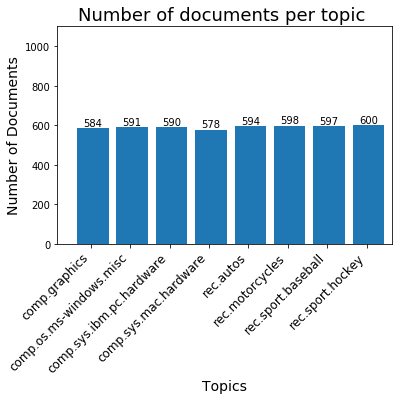

In [6]:
number_of_documents = []

for i in range(len(train_dataset.target_names)):
    number_of_documents.append(len([x for x in train_dataset.target if x == i]))
    
#plot histogram
x_labels = train_dataset.target_names
fig, ax = plt.subplots()
ax.set_xticks([i+0.35 for i in range(1,9)])
ax.set_xticklabels(x_labels, rotation=45, ha='right', fontsize = 12)

rects = plt.bar([i for i in range(1,9)], number_of_documents, align='edge')
plt.xlabel('Topics', fontsize = 14)
plt.ylabel('Number of Documents', fontsize = 14)
plt.title('Number of documents per topic ', fontsize = 18)
plt.axis([0.5,9,0,1100])
    
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., 1*height, '%d' % int(height), ha='center', va='bottom')
    
plt.show()

# Binary Classification

In [17]:
# 1. Feature Extraction

In [4]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc',
'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
'rec.autos', 'rec.motorcycles',
'rec.sport.baseball', 'rec.sport.hockey']

In [5]:
train_dataset = fetch_20newsgroups(subset='train', categories=categories,
shuffle=True, random_state=42, remove=('headers'))

test_dataset = fetch_20newsgroups(subset='test', categories=categories,
shuffle=True, random_state=42, remove=('headers'))

In [20]:
# QUESTION 2: Use the following specs to extract features from the textual data:
# • Use the default stopwords of the CountVectorizer
# • Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
# • Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos_tag
# • Use min_df=3
# Report the shape of the TF-IDF matrices of the train and test subsets respectively.

In [7]:
# we need to Lemmatize this.
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 
    
def lemmatize_parse(text):
    wnl = nltk.wordnet.WordNetLemmatizer()
    lemmatize = []
    for word, tag in pos_tag(nltk.word_tokenize(text)):
        if(word.isdigit() or word.isalpha()):
            lemmatize.append(wnl.lemmatize(word.lower(), pos=penn2morphy(tag)))
    return lemmatize

In [8]:
# set lemmatize 
train_data_lemmatized = []
for item in train_dataset.data:
    train_data_lemmatized.append(' '.join(lemmatize_parse(item)))
    
test_dataset_lemmatized = []
for item in test_dataset.data:
    test_dataset_lemmatized.append(' '.join(lemmatize_parse(item)))
    
train_dataset.data = train_data_lemmatized
test_dataset.data = test_dataset_lemmatized

In [9]:
vectorizer = CountVectorizer(min_df=3, stop_words='english')
X_train_counts = vectorizer.fit_transform(train_dataset.data)
X_test_counts = vectorizer.transform(test_dataset.data)

# need to find position of terms where there are alpha_numeric and remove them in term/doc matrix
# alpha_numeric_terms_position = [idx for idx,term in enumerate(vectorizer.get_feature_names()) if term.isdigit()]


In [10]:
# delete term position where it's alpha numeric.
# X_train_counts_clean = np.delete(X_train_counts.toarray(), alpha_num_terms_position, axis=1)
# X_test_counts_clean = np.delete(X_test_counts.toarray(), alpha_num_terms_position, axis=1)

# delete alpha_numeric terms out from original feature_names()
# feature_names = array(vectorizer.get_feature_names())
# feature_names_clean = np.delete(feature_names, alpha_numeric_terms_position, axis=0)


In [11]:
# generate TFxIDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.fit_transform(X_test_counts)


In [12]:
X_train_tfidf.shape

(4732, 12033)

In [13]:
X_test_tfidf.shape

(3150, 12033)

In [402]:
# QUESTION 3: Reduce the dimensionality of the data using the methods above
# • Apply LSI to the TF-IDF matrix corresponding to the 8 categories with k = 50;
# so each document is mapped to a 50-dimensional vector.
# • Also reduce dimensionality through NMF and compare with LSI:
# Which one is larger?

In [15]:
# using LSI
svd = TruncatedSVD(n_components = 50,random_state = 42)
svd_res = svd.fit_transform(X_train_tfidf)
print('LSI method:')
print(svd_res.shape)
print('')

# using NMF
nmf = NMF(n_components=50, init='random', random_state=42)
nmf_res = nmf.fit_transform(X_train_tfidf)
print('NMF method:')
print(nmf_res.shape)
print('')


LSI method:
(4732, 50)

NMF method:
(4732, 50)



In [406]:
# QUESTION 4: Hard margin and soft margin linear SVMs:
# • Train two linear SVMs and compare:
# – Train one SVM with y= 1000 (hard margin), another with y= 0:0001 (soft margin).
# – Plot the ROC curve, report the confusion matrix and calculate the accuracy,
# recall, precision and F-1 score of both SVM classifier. Which
# one performs better?
# – What happens for the soft margin SVM? Why is the case?
# • Use cross-validation to choose y:
# Using a 5-fold cross-validation, find the best value of the parameter 
#  in the range f10kj 􀀀 3  k  3; k 2 Zg. Again, plot the ROC curve and report the
# confusion matrix and calculate

In [408]:
#hard margin
hard_svm = svm.SVC(kernel='linear', gamma = 1000)
hard_svm.fit(X_train_tfidf, train_dataset.target)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [409]:
predicted = hard_svm.predict(X_test_tfidf.toarray())

In [410]:
pd.crosstab(test_dataset['target'].ravel(), predicted, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,7,All
True,,,
0,4,385,389
1,0,394,394
2,0,392,392
3,0,385,385
4,0,396,396
5,0,398,398
6,0,397,397
7,0,399,399
All,4,3146,3150


In [18]:
# soft-margin SVC
svc_softmargin = SVC(kernel='linear', gamma=0.0001)

In [16]:
# combined X training matrices for iteraiton
X_news = [X_train_tfidf, svd_res, nmf_res]
# X_news_test = [X_test_tfidf, , ]
# y training
y_news = train_dataset.target
# y_test
y_news_test = test_dataset.target

In [27]:
# print out SVC soft-margin ROC, Confusion, Accuracy, Recall, Precision for tfidf, lsi, nmf datasets
labels = ['TFIDF', 'LSI', 'NMF']
for idx, x in enumerate(X_news):
    svc_softmargin.fit(x, y_news)
    svc_softmargin_pred = svc_softmargin.predict(x)
    #svc_softmargin_roc = roc_curve(y_true=y_news, y_score=svc_softmargin_pred)
    svc_softmargin_confusion = confusion_matrix(y_true=y_news, y_pred=svc_softmargin_pred)
    svc_softmargin_accuracy = accuracy_score(y_true=y_news, y_pred=svc_softmargin_pred)
    #svc_softmargin_recall = recall_score(y_true=y_news, y_pred=svc_softmargin_pred, average='samples')
    #svc_softmargin_precision = precision_score(y_true=y_news, y_pred=svc_softmargin_pred)
    #svc_softmargin_f1 = f1_score(y_true=y_news, y_pred=svc_softmargin_pred)
    #print("Training-set SVC Soft-margin " + labels[idx] + " ROC curve: " + svc_softmargin_roc)
    print("Training-set SVC Soft-margin " + labels[idx] + " Confusion matrix: " + str(svc_softmargin_confusion))
    print("Training-set SVC Soft-margin " + labels[idx] + " Accuracy Score: " + str(svc_softmargin_accuracy))
    #print("Training-set SVC Soft-margin " + labels[idx] + " Recall Score: " + svc_softmargin_recall)
    #print("Training-set SVC Soft-margin " + labels[idx] + " Precision Score: " + svc_softmargin_precision)
    #print("Training-set SVC Soft-margin " + labels[idx] + " F1 Score: " + svc_softmargin_f1)

Training-set SVC Soft-margin TFIDF Confusion matrix: [[574   5   4   1   0   0   0   0]
 [  6 577   6   2   0   0   0   0]
 [  4  11 574   1   0   0   0   0]
 [  3   0   5 570   0   0   0   0]
 [  2   0   0   1 591   0   0   0]
 [  3   0   1   1   0 593   0   0]
 [  2   0   0   0   0   0 595   0]
 [  1   0   0   2   1   0   0 596]]
Training-set SVC Soft-margin TFIDF Accuracy Score: 0.9868977176669484
Training-set SVC Soft-margin LSI Confusion matrix: [[484  40  26  15   8   1   9   1]
 [ 80 437  51   9   6   3   5   0]
 [ 57  53 422  41  10   1   6   0]
 [ 36  16  82 428   6   5   5   0]
 [ 19   8  12   1 516  26  12   0]
 [  6   4   5   2  36 533  11   1]
 [  8   3   1   0   2   2 567  14]
 [  4   0   8   0   8   1  30 549]]
Training-set SVC Soft-margin LSI Accuracy Score: 0.8317836010143702
Training-set SVC Soft-margin NMF Confusion matrix: [[451  49  42  17  13   0  12   0]
 [127 337 107   6   4   0   8   2]
 [ 73  26 448  22  15   0   6   0]
 [ 53  11 216 283   6   0   9   0]
 [ 42

# GridSearchCV

In [30]:
# GridSearch, 5-fold CV
svc = SVC()
param_grid = {'gamma':np.arange(0.001, 1000)}
gs_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, scoring='accuracy')
gs_svc.fit(X_tfidf, y_news)
# best gamma:
best_gamma = gs_svc.best_estimator_
print("Optimal gamma for SVC: " + best_gamma)

NameError: name 'X_tfidf' is not defined

In [ ]:
# SVC using best gamma for dataset
svc_bestgamma = SVC(gamma=best_gamma)

In [ ]:
for idx, x in enumerate(X_news):
    svc_bestgamma.fit(x, y_news)
    svc_bestgamma_pred = svc_bestgamma.predict(x)
    #svc_bestgamma_roc = roc_curve(y_true=y_news, y_score=svc_bestgamma_pred)
    svc_bestgamma_confusion = confusion_matrix(y_true=y_news, y_pred=svc_bestgamma_pred)
    svc_bestgamma_accuracy = accuracy_score(y_true=y_news, y_pred=svc_bestgamma_pred)
    #svc_bestgamma_recall = recall_score(y_true=y_news, y_pred=svc_bestgamma_pred)
    #svc_bestgamma_precision = precision_score(y_true=y_news, y_pred=svc_bestgamma_pred)
    #svc_bestgamma_f1 = f1_score(y_true=y_news, y_pred=svc_bestgamma_pred)
    #print("SVC Best-gamma " + labels[idx] + " ROC curve: " + svc_bestgamma_roc)
    print("SVC Best-gamma " + labels[idx] + " Confusion matrix: " + str(svc_bestgamma_confusion))
    print("SVC Best-gamma " + labels[idx] + " Accuracy Score: " + str(svc_bestgamma_accuracy))
    #print("SVC Best-gamma " + labels[idx] + " Recall Score: " + str(svc_bestgamma_recall))
    #print("SVC Best-gamma " + labels[idx] + " Precision Score: " + str(svc_bestgamma_precision))
    #print("Training-set SVC Best-gamma " + labels[idx] + " F1 Score: " + str(svc_bestgamma_f1))

# NaiveBayes Classifier

In [34]:
# NaiveBayes classifier
mnb = MultinomialNB()
labels = ['TFIDF', 'LSI', 'NMF']
for idx, x in enumerate(X_news):
    mnb.fit(x, y_news)
    mnb_pred = mnb.predict(x)
    #mnb_roc = roc_curve(y_true=y_news, y_score=mnb_pred)
    mnb_confusion = confusion_matrix(y_true=y_news, y_pred=mnb_pred)
    mnb_accuracy = accuracy_score(y_true=y_news, y_pred=mnb_pred)
    #mnb_recall = recall_score(y_true=y_news, y_pred=mnb_pred)
    #mnb_precision = precision_score(y_true=y_news, y_pred=mnb_pred)
    #mnb_f1 = f1_score(y_true=y_news, y_pred=mnb_pred)
    #print("Multinomial Naive Bayes " + labels[idx] + " ROC curve: " + str(mnb_roc))
    print("Multinomial Naive Bayes " + labels[idx] + " Confusion matrix: " + str(mnb_confusion))
    print("Multinomial Naive Bayes " + labels[idx] + " Accuracy Score: " + str(mnb_accuracy))
    #print("Multinomial Naive Bayes " + labels[idx] + " Recall Score: " + str(mnb_recall))
    #print("Multinomial Naive Bayes " + labels[idx] + " Precision Score: " + str(mnb_precision))
    #print("Training-set SVC Best-gamma " + labels[idx] + " F1 Score: " + str(mnb_f1))

Multinomial Naive Bayes TFIDF Confusion matrix: [[546  10  17   5   0   2   0   4]
 [  9 545  33   1   0   0   1   2]
 [  9  18 553   6   1   0   0   3]
 [  4   7  14 547   2   1   1   2]
 [  1   4   2   2 574   6   3   2]
 [  3   0   1   2   3 588   0   1]
 [  1   0   0   0   0   0 589   7]
 [  1   1   3   1   1   0   2 591]]
Multinomial Naive Bayes TFIDF Accuracy Score: 0.9579459002535926


ValueError: Input X must be non-negative

# Grid Search of Parameters

In [35]:
from sklearn.pipeline import Pipeline

In [ ]:
models = [sc=Standard,fe=, clf='']

In [ ]:
param_grid = {'gamma':np.arange(0.001, 1000)} # edit to put in features to gridsearch

In [ ]:
pipe = Pipeline(models)

In [261]:
pipe.fit(X_train_tfidf) # example

LSI method:
(4732, 50)

NMF method:
(4732, 50)



# Multiclass Classification



In [37]:
from sklearn.datasets import fetch_20newsgroups

In [44]:

# 1. get categories
multi_categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']
# 2. clean dataset, tokenize, remove stop words and punctuation, and stem
multi_data = fetch_20newsgroups(subset='train', categories=multi_categories, shuffle=True, random_state=42)
multi_data_cleaned = vectorizer.fit_transform(multi_data.data)

In [42]:
multiclass_data = multi_data_cleaned
# transform data for TFIDF, LSI, NMF comparison
tfidf_multi = tfidf.fit_transform(multiclass_data).toarray()
lsi_multi = lsi.fit_transform(multiclass_data)
nmf_multi = nmf.fit_transform(multiclass_data)

NameError: name 'multi_data_cleaned' is not defined

In [ ]:
X_multi = [tfidf_multi, lsi_multi, nmf_multi]
y_multi = multi_data.target

In [ ]:

# Naive Bayes
multiclass_NB = MultinomialNB()
labels = ['TFIDF', 'LSI', 'NMF']
for idx, x in enumerate(X_multi):
    multiclass_NB.fit(x, y_multi)
    multiclass_NB_pred = multiclass_NB.predict(x)
    multiclass_NB_roc = roc_curve(y_true=y_multi, y_score=multiclass_NB_pred)
    multiclass_NB_confusion = confusion_matrix(y_true=y_multi, y_pred=multiclass_NB_pred)
    multiclass_NB_accuracy = accuracy_score(y_true=y_multi, y_pred=multiclass_NB_pred)
    multiclass_NB_recall = recall_score(y_true=y_multi, y_pred=multiclass_NB_pred)
    multiclass_NB_precision = precision_score(y_true=y_multi, y_pred=multiclass_NB_pred)
    multiclass_NB_f1 = f1_score(y_true=y_multi, y_pred=multiclass_NB_pred)
    print("Multiclass NaiveBayes " + labels[idx] + " ROC curve: " + multiclass_NB_roc)
    print("Multiclass NaiveBayes " + labels[idx] + " Confusion matrix: " + multiclass_NB_confusion)
    print("Multiclass NaiveBayes " + labels[idx] + " Accuracy Score: " + multiclass_NB_accuracy)
    print("Multiclass NaiveBayes " + labels[idx] + " Recall Score: " + multiclass_NB_recall)
    print("Multiclass NaiveBayes " + labels[idx] + " Precision Score: " + multiclass_NB_precision)
    print("Multiclass NaiveBayes " + labels[idx] + " f1 Score: " + multiclass_NB_f1)


